# Calories Counter Project

## Imports

In [ ]:
from packaging import version
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

##Helper Function

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
def evaluation(model,X_test, y_test):
  y_pred = model.predict(X_test)

  y_pred = np.abs(y_pred)

  # Evaluate the performance using a suitable metric, e.g., Root Mean Squared Error (RMSE)

  rmse = mean_squared_error(y_test, y_pred)
  rmsle_val = rmsle(y_test, y_pred)

  print(f"RMSE on the test set: {rmse}")
  print(f"RMSLE on the test set: {rmsle_val}")

  # You can also visualize the predictions vs actual values
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.xlabel("Actual Calories")
  plt.ylabel("Predicted Calories")
  plt.title("Actual vs. Predicted Calories (Test Set)")
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
  plt.show()

def save_submission_file(model):
  sample_submission_path = f'{unzip_directory}/sample_submission.csv'
  # Load the sample_submission.csv file
  submission_df = pd.read_csv(sample_submission_path)

  # Ensure the test_df has the same columns as the training data (excluding the target 'Calories')
  # and in the same order, before making predictions.
  # Assuming X_train contains the columns used for training.
  test_df_aligned = test_df[X_train.columns]

  # Make predictions on the aligned test data using the trained pipeline
  test_predictions = model.predict(test_df_aligned)

  # Since calories cannot be negative, ensure predictions are non-negative
  test_predictions = np.abs(test_predictions)

  # Replace the 'Calories' column in the submission DataFrame with the predictions
  submission_df['Calories'] = test_predictions.round().astype(int) # Round and convert to integer if appropriate

  # Display the first few rows of the updated submission DataFrame
  print(submission_df.head())

  # Save the updated submission DataFrame to a new CSV file (or overwrite the original)
  # For example, to a new file:
  # output_submission_path = f'{unzip_directory}/submission_with_predictions.csv'
  # submission_df.to_csv(output_submission_path, index=False)

  # Or to overwrite the original:
  submission_df.to_csv(sample_submission_path, index=False)

  print(f"Predictions saved to {sample_submission_path}")


## Download Data

In [ ]:
# prompt: help me download and unzip the following shared file: https://drive.google.com/file/d/1S8YoUUNWUWXebWfssg9wHRNB-y1s_ZNh/view?usp=drive_link
# https://drive.google.com/file/d/1S8YoUUNWUWXebWfssg9wHRNB-y1s_ZNh/view?usp=sharing
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download the file from Google Drive
# You need to replace 'FILE_ID' with the actual file ID from the link.
# The file ID is the part after /d/ and before /view
# For the provided link: 1S8YoUUNWUWXebWfssg9wHRNB-y1s_ZNh
file_id = '1S8YoUUNWUWXebWfssg9wHRNB-y1s_ZNh'
download_path = '/content/downloaded_file.zip' # You can change the filename

!gdown --id {file_id} -O {download_path}

# Unzip the downloaded file
unzip_directory = '/content/unzipped_content' # Directory to unzip to
!mkdir -p {unzip_directory} # Create the directory if it doesn't exist
!unzip {download_path} -d {unzip_directory}

# List the contents of the unzipped directory to verify
!ls {unzip_directory}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S8YoUUNWUWXebWfssg9wHRNB-y1s_ZNh
To: /content/downloaded_file.zip
100% 13.1M/13.1M [00:00<00:00, 50.5MB/s]
Archive:  /content/downloaded_file.zip
replace /content/unzipped_content/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/unzipped_content/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/unzipped_content/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
sample_submission.csv  test.csv  train.csv


## Data Exploration

In [ ]:
# Define the path to the train.csv file within the unzipped directory
train_data_path = f'{unzip_directory}/train.csv'

# Load the train.csv file into a pandas DataFrame
train_df = pd.read_csv(train_data_path)

### Take a Quick Look at the Data Structure

In [ ]:
# Display the first few rows of the DataFrame to verify
print(train_df.head())

   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0


In [ ]:
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None


In [ ]:
train_df["Sex"].value_counts()

,count
Sex,
female,375721
male,374279


In [ ]:
train_df.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


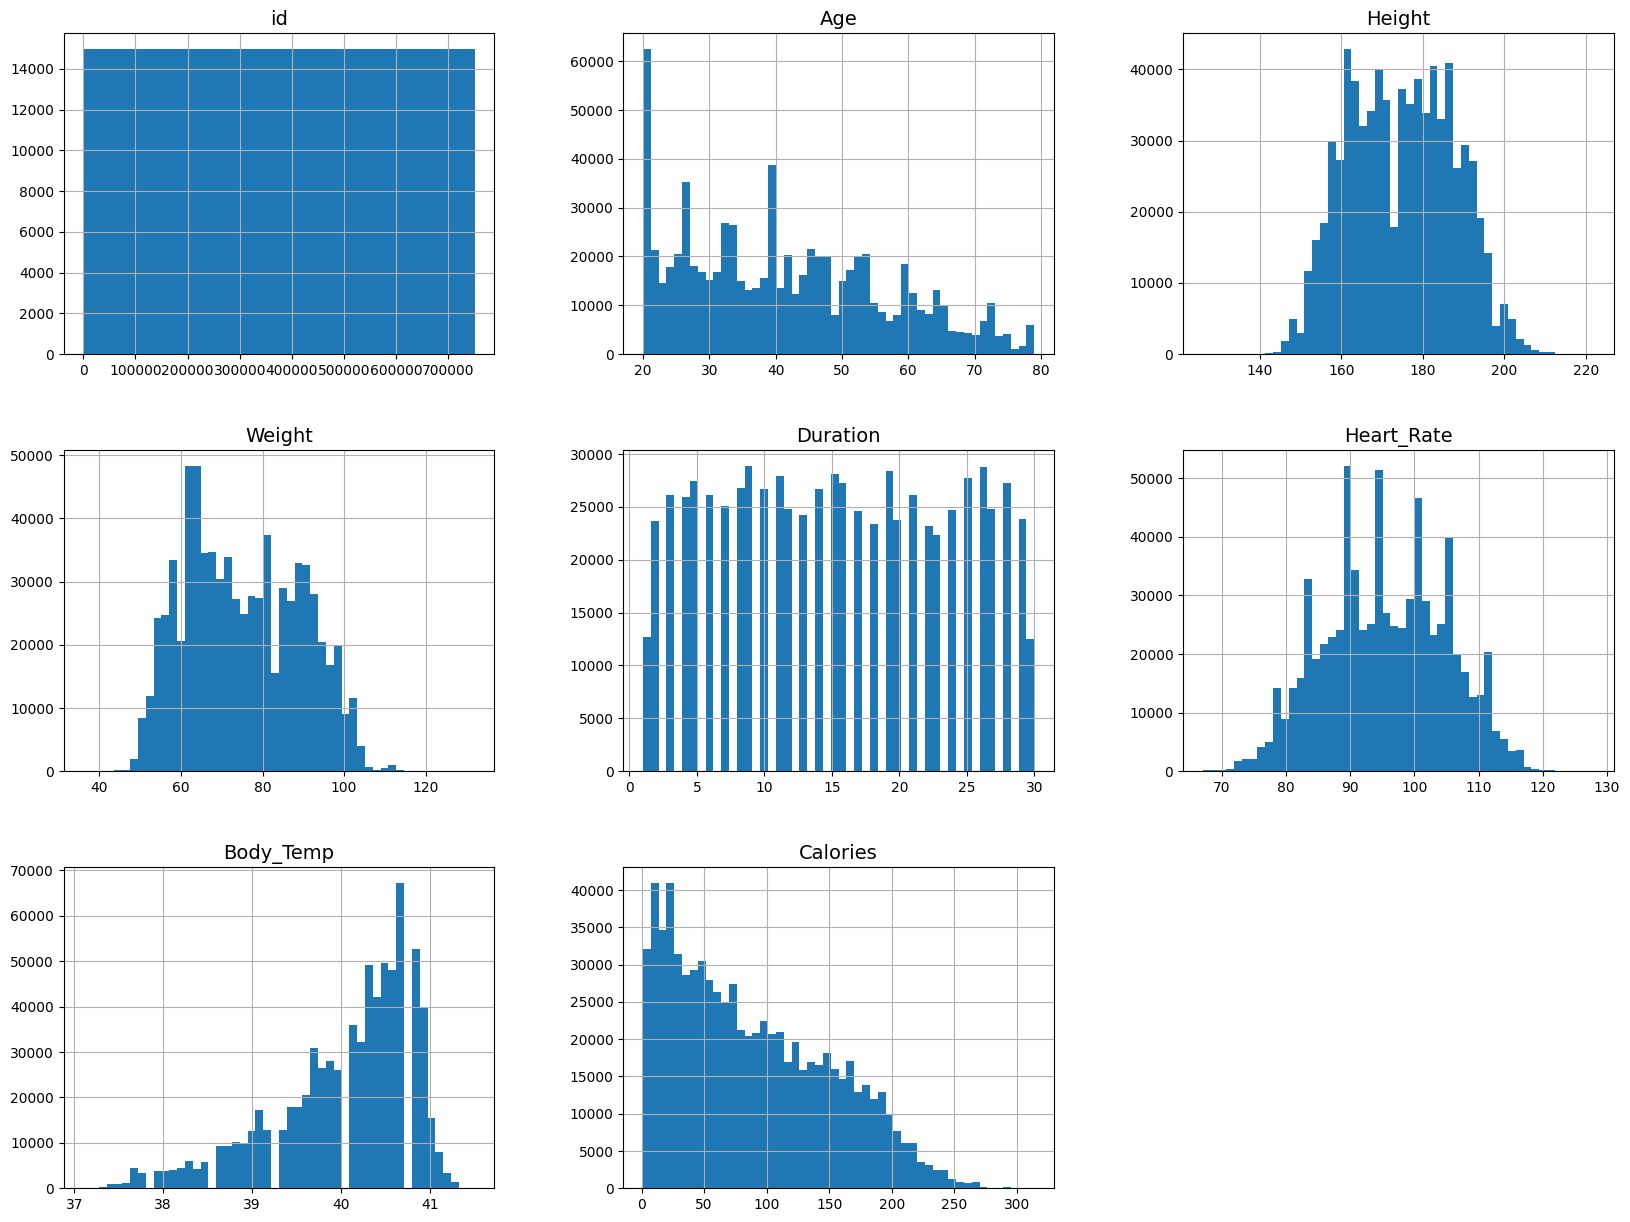

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_df.hist(bins=50, figsize=(20,15))
plt.show()

To ensure that the outputs are consistent, random seed will be set

In [ ]:
np.random.seed(42)

### Correlation Analysis

In [ ]:
corr_matrix = train_df.corr(numeric_only=True)

In [ ]:
#Correlation with heart rate
corr_matrix["Heart_Rate"].sort_values(ascending=False)

,Heart_Rate
Heart_Rate,1.000000
Calories,0.908748
Duration,0.875327
Body_Temp,0.795972
Age,0.017037
id,0.001092
Weight,-0.002384
Height,-0.013234


In [ ]:
#Correlation with weight
corr_matrix["Weight"].sort_values(ascending=False)

,Weight
Weight,1.000000
Height,0.957967
Age,0.073690
Calories,0.015863
id,0.000524
Heart_Rate,-0.002384
Duration,-0.020845
Body_Temp,-0.023717


In [ ]:
#Correlation with age
corr_matrix["Age"].sort_values(ascending=False)

,Age
Age,1.000000
Calories,0.145683
Weight,0.073690
Body_Temp,0.030275
Heart_Rate,0.017037
Duration,0.015656
Height,0.011975
id,0.002330


In [ ]:
#Correlation with duration
corr_matrix["Duration"].sort_values(ascending=False)

,Duration
Duration,1.000000
Calories,0.959908
Body_Temp,0.903066
Heart_Rate,0.875327
Age,0.015656
id,0.001647
Weight,-0.020845
Height,-0.029936


In [ ]:
#Correlation with calories
corr_matrix["Calories"].sort_values(ascending=False)

,Calories
Calories,1.000000
Duration,0.959908
Heart_Rate,0.908748
Body_Temp,0.828671
Age,0.145683
Weight,0.015863
id,0.001148
Height,-0.004026


In [ ]:
#Correlation with height
corr_matrix["Height"].sort_values(ascending=False)

,Height
Height,1.000000
Weight,0.957967
Age,0.011975
id,0.000101
Calories,-0.004026
Heart_Rate,-0.013234
Duration,-0.029936
Body_Temp,-0.034641


## Cleaning the Data

In [ ]:
#Changing sex category from female and male to 0 and 1, respectively
ordinal_encoder = OrdinalEncoder()
sex_cat = train_df[["Sex"]]
sex_encoded = ordinal_encoder.fit_transform(sex_cat)

In [ ]:
#Checking the data
sex_encoded[:10]
#ordinal_encoder.categories_
#train_df.head()

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [ ]:
# prompt: replace the sex category with the encoded values (0,1)

train_df["Sex"] = sex_encoded
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,1.0,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,0.0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,0.0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,1.0,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,0.0,38,166.0,61.0,25.0,102.0,40.6,146.0


In [ ]:
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_set

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
453635,453635,1.0,43,190.0,89.0,6.0,87.0,39.1,25.0
11651,11651,0.0,48,155.0,54.0,12.0,97.0,40.2,67.0
431999,431999,1.0,51,187.0,92.0,15.0,96.0,40.5,86.0
529211,529211,1.0,45,182.0,88.0,2.0,83.0,38.3,5.0
110925,110925,1.0,22,202.0,99.0,25.0,98.0,40.7,122.0
...,...,...,...,...,...,...,...,...,...
259178,259178,1.0,58,179.0,78.0,9.0,93.0,39.7,48.0
365838,365838,0.0,46,171.0,70.0,16.0,85.0,39.8,64.0
131932,131932,1.0,37,191.0,91.0,28.0,108.0,40.7,192.0
671155,671155,1.0,42,193.0,92.0,17.0,93.0,40.0,81.0


## Training the Baseline

In [ ]:
# prompt: split the pandas into a trianing set x and a label y, where labels are the calories

X_train = train_set.drop("Calories", axis=1)
y_train = train_set["Calories"].copy()

X_train.shape, y_train.shape

#y[:10]

((600000, 8), (600000,))

In [ ]:
X_test = test_set.drop("Calories", axis=1)
y_test = test_set["Calories"].copy()

X_test.shape, y_test.shape

((150000, 8), (150000,))

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [ ]:
lin_rmses = -cross_val_score(lin_reg, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

,0
count,10.000000
mean,11.107141
std,0.061876
min,11.044843
25%,11.050693
50%,11.096353
75%,11.162892
max,11.190314


## Evaluate the Test Set

In [ ]:
# prompt: please help me load the test set "test.csv" from the folder "unzipped_content"

# Define the path to the test.csv file within the unzipped directory
test_data_path = f'{unzip_directory}/test.csv'

# Load the test.csv file into a pandas DataFrame
test_df = pd.read_csv(test_data_path)

# Display the first few rows of the test DataFrame to verify
print(test_df.head())
print(test_df.info())

       id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    male   45   177.0    81.0       7.0        87.0       39.8
1  750001    male   26   200.0    97.0      20.0       101.0       40.5
2  750002  female   29   188.0    85.0      16.0       102.0       40.4
3  750003  female   39   172.0    73.0      20.0       107.0       40.6
4  750004  female   30   173.0    67.0      16.0        94.0       40.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1

In [ ]:
sex_cat_test = test_df[["Sex"]]
sex_encoded_test = ordinal_encoder.fit_transform(sex_cat_test)

In [ ]:
test_df["Sex"] = sex_encoded_test
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,1.0,45,177.0,81.0,7.0,87.0,39.8
1,750001,1.0,26,200.0,97.0,20.0,101.0,40.5
2,750002,0.0,29,188.0,85.0,16.0,102.0,40.4
3,750003,0.0,39,172.0,73.0,20.0,107.0,40.6
4,750004,0.0,30,173.0,67.0,16.0,94.0,40.5


##Improvement 1 Feature Scaling

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline.fit(X_test, y_test)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

RMSE on the test set: 111.39884753733575
RMSLE on the test set: 0.39219870134246954


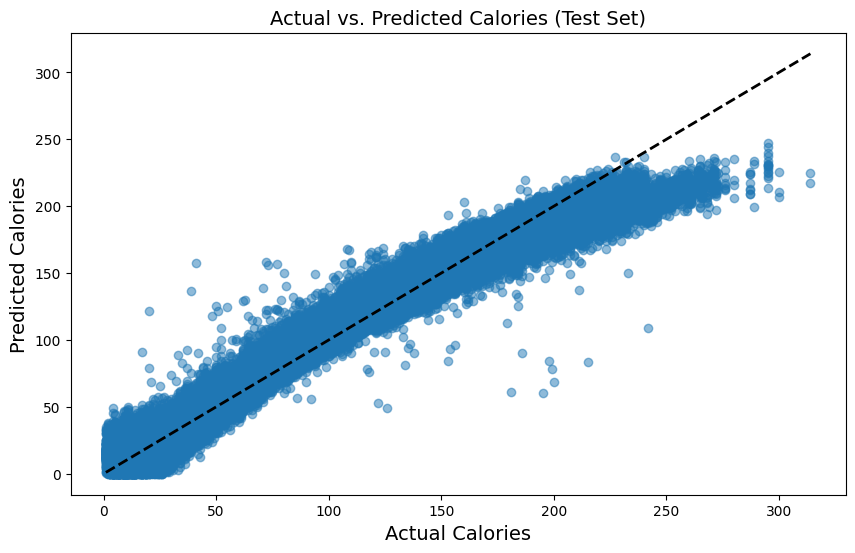

In [ ]:
evaluation(pipeline,X_test, y_test)

In [ ]:
# Define the path to the test.csv file within the unzipped directory
test_data_path = f'{unzip_directory}/test.csv'

# Load the test.csv file into a pandas DataFrame
test_df = pd.read_csv(test_data_path)

# Display the first few rows of the test DataFrame to verify
print(test_df.head())
print(test_df.info())

       id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    male   45   177.0    81.0       7.0        87.0       39.8
1  750001    male   26   200.0    97.0      20.0       101.0       40.5
2  750002  female   29   188.0    85.0      16.0       102.0       40.4
3  750003  female   39   172.0    73.0      20.0       107.0       40.6
4  750004  female   30   173.0    67.0      16.0        94.0       40.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1

In [ ]:
sex_cat_test = test_df[["Sex"]]
sex_encoded_test = ordinal_encoder.fit_transform(sex_cat_test)
print(sex_encoded_test[:10])

[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
test_df["Sex"] = sex_encoded_test
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,1.0,45,177.0,81.0,7.0,87.0,39.8
1,750001,1.0,26,200.0,97.0,20.0,101.0,40.5
2,750002,0.0,29,188.0,85.0,16.0,102.0,40.4
3,750003,0.0,39,172.0,73.0,20.0,107.0,40.6
4,750004,0.0,30,173.0,67.0,16.0,94.0,40.5


In [ ]:
save_submission_file(pipeline)

       id  Calories
0  750000        21
1  750001       115
2  750002        93
3  750003       131
4  750004        74
Predictions saved to /content/unzipped_content/sample_submission.csv


## Improvement: Use a Decision Tree or Random Forest

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

RMSE on the test set: 26.8091
RMSLE on the test set: 0.08560847665880163


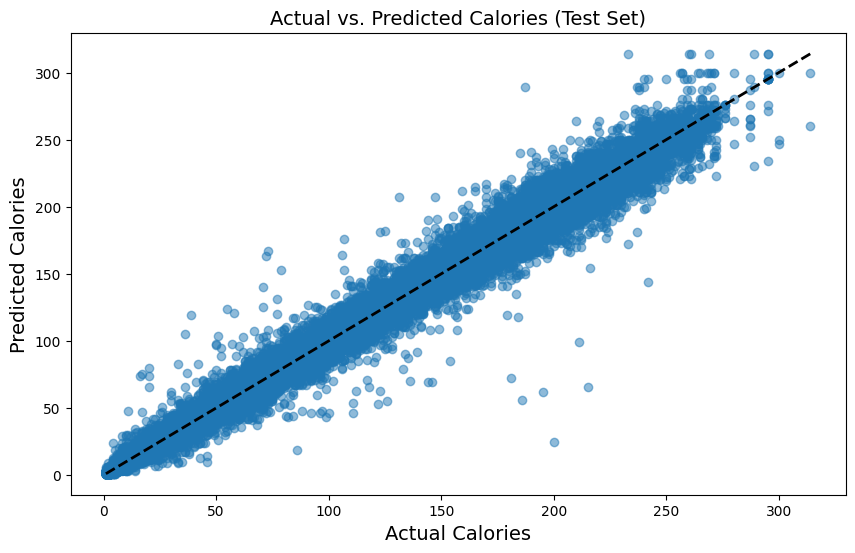

In [ ]:

evaluation(tree_reg,X_test, y_test)


In [ ]:
save_submission_file(tree_reg)

       id  Calories
0  750000        27
1  750001       110
2  750002        85
3  750003       126
4  750004        75
Predictions saved to /content/unzipped_content/sample_submission.csv


In [ ]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

##Improvement 2 - Forest Regression Evaluation

RMSE on the test set: 14.404542067333333
RMSLE on the test set: 0.06266249264374431


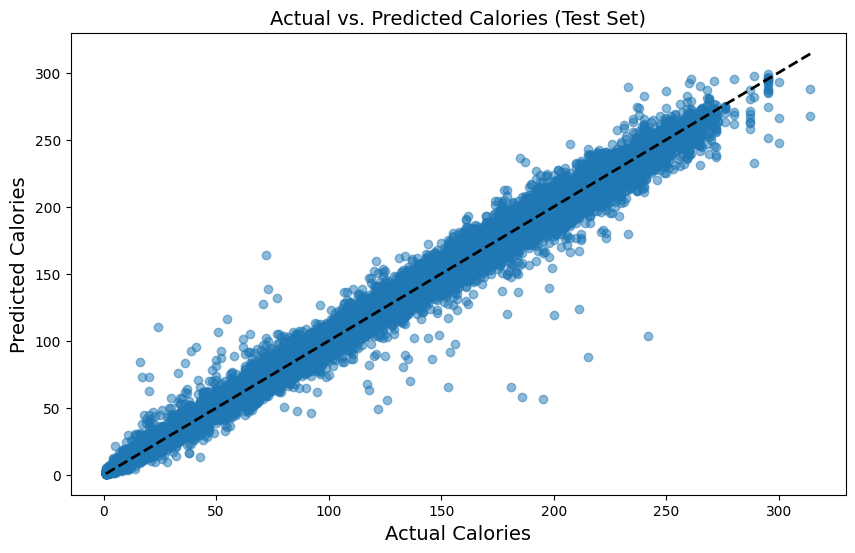

In [ ]:
evaluation(forest_reg,X_test, y_test)

In [ ]:
save_submission_file(forest_reg)

       id  Calories
0  750000        27
1  750001       107
2  750002        88
3  750003       127
4  750004        76
Predictions saved to /content/unzipped_content/sample_submission.csv


## Improvement 3 - Grid Search

In [ ]:
full_pipeline = Pipeline([

    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {
     'random_forest__max_features': [2, 3, 4, 5, 6]}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [2, 3, 4, 5, 6]}],
             scoring='neg_root_mean_squared_error')

##Improvement 4 - Feature Engineering

In [ ]:
# Define the path to the train.csv and test.csv files within the unzipped directory
train_data_path = f'{unzip_directory}/train.csv'
test_data_path = f'{unzip_directory}/test.csv'

# Load the train.csv and test.csv files into pandas DataFrames
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

#Changing sex category from female and male to 0 and 1, respectively
ordinal_encoder = OrdinalEncoder()
sex_cat_train = train_df[["Sex"]]
sex_encoded_train = ordinal_encoder.fit_transform(sex_cat_train)
train_df["Sex"] = sex_encoded_train

sex_cat_test = test_df[["Sex"]]
sex_encoded_test = ordinal_encoder.fit_transform(sex_cat_test)
test_df["Sex"] = sex_encoded_test


# I want to add a new feature to the data set, which is BMI (BMI = weight / height², where weight is in kilograms and weight is in meters

train_df["BMI"] = train_df["Weight"] / (train_df["Height"] / 100)**2
test_df["BMI"] = test_df["Weight"] / (test_df["Height"] / 100)**2

train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

X_train = train_set.drop("Calories", axis=1)
y_train = train_set["Calories"].copy()

X_test = test_set.drop("Calories", axis=1)
y_test = test_set["Calories"].copy()

X_train.shape, y_train.shape
X_test.shape, y_test.shape

((150000, 9), (150000,))

In [ ]:
# prompt: confirm that the data include bmi print it

# Verify that the 'BMI' column was added to the DataFrame
print(train_df.head())

# Print information about the DataFrame including the new 'BMI' column
#print(train_df.info())

   id  Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  \
0   0  1.0   36   189.0    82.0      26.0       101.0       41.0     150.0   
1   1  0.0   64   163.0    60.0       8.0        85.0       39.7      34.0   
2   2  0.0   51   161.0    64.0       7.0        84.0       39.8      29.0   
3   3  1.0   20   192.0    90.0      25.0       105.0       40.7     140.0   
4   4  0.0   38   166.0    61.0      25.0       102.0       40.6     146.0   

         BMI  
0  22.955684  
1  22.582709  
2  24.690405  
3  24.414062  
4  22.136740  


In [ ]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

evaluation(forest_reg, X_test, y_test)
save_submission_file(forest_reg)

In [ ]:
# prompt: suggest a feature to see if there's a ratio between duration and heart rate. also suggest a feature that corresponds to the intensity based on the heart rate and the duration

train_df['Heart_Rate_Duration_Ratio'] = train_df['Heart_Rate'] / train_df['Duration']
test_df['Heart_Rate_Duration_Ratio'] = test_df['Heart_Rate'] / test_df['Duration']


In [ ]:
# prompt: create a feature of heart rate times duration to allow curvature

train_df['Heart_Rate_Duration_Squared'] = (train_df['Heart_Rate'] * train_df['Duration'])**2
test_df['Heart_Rate_Duration_Squared'] = (test_df['Heart_Rate'] * test_df['Duration'])**2

X_train = train_set.drop("Calories", axis=1)
y_train = train_set["Calories"].copy()

X_test = test_set.drop("Calories", axis=1)
y_test = test_set["Calories"].copy()


In [ ]:
# prompt: create a new feature of body temp and heart rate ratio

train_df['Body_Temp_Heart_Rate_Ratio'] = train_df['Body_Temp'] / train_df['Heart_Rate']
test_df['Body_Temp_Heart_Rate_Ratio'] = test_df['Body_Temp'] / test_df['Heart_Rate']

# Update the X_train and X_test DataFrames to include the new feature
# It's important to ensure X_train and X_test reflect the features used in the pipeline/model training
# If the subsequent steps will use X_train and X_test directly, update them here.
# If they will use the full train_df and test_df with a pipeline, the previous steps adding columns to train_df/test_df are sufficient.

# For example, if you rebuild X_train and X_test:
X_train = train_df.drop("Calories", axis=1)
y_train = train_df["Calories"].copy()

X_test = test_df.drop("Calories", axis=1)
y_test = test_df["Calories"].copy()

print("Updated X_train with new feature:")
print(X_train.head())
print("\nUpdated X_test with new feature:")
print(X_test.head())

## Improvement 5 - Ensemble Learning

In [ ]:
# 1. Instantiate your chosen regressors
reg1 = Ridge(alpha=1.0)
reg2 = RandomForestRegressor(n_estimators=100, random_state=42)
reg3 = SVR(kernel='rbf', C=100)

# 2. Create the VotingRegressor
# The 'estimators' argument is a list of tuples, where each tuple contains
# a name for the regressor and the regressor object itself.
voting_regressor = VotingRegressor(
    estimators=[('ridge', reg1), ('rf', reg2), ('svr', reg3)]
)

# 3. Fit the model on your training data
voting_regressor.fit(X_train, y_train)

# 4. Make predictions
#  predictions = voting_regressor.predict(X_test)